# Классификация дефектов кожи

In [1]:
#!pip install -q tensorflow==2.3
#!pip install keras_efficientnets
#!pip freeze > requirements.txt

# Импортируем библиотеки 

In [2]:
# Импортируем библиотеки

import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import re
import random
import os
import sys
import PIL
import cv2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import ExtraTreeRegressor
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import itertools 

#from catboost import CatBoostRegressor

from tqdm import tqdm
from tqdm.notebook import tqdm

from itertools import combinations
from scipy.stats import ttest_ind


# # keras
import tensorflow as tf
from tensorflow import keras
#import tensorflow.keras.layers as L
#from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#import albumentations
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
#import tensorflow as tf
import tensorflow.keras 
import tensorflow.keras.models #as M
#import tensorflow.keras.layers as L
#import tensorflow.keras.backend #as K
from tensorflow.keras import optimizers

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from glob import glob
from glob import iglob
#from keras.applications import InceptionV3
#from keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense ,LeakyReLU,UpSampling2D, GlobalAveragePooling2D,Conv2DTranspose, BatchNormalization,GlobalMaxPool2D, Convolution2D

import nltk
from nltk.corpus import stopwords

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
#DATA_PATH = "/content/drive/My Drive/cars2/"
#PATH = "/content/"  # рабочая директория

In [3]:
#from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB4
print(keras.__version__)
print(tf.__version__)

2.4.0
2.4.0


In [4]:
print(tf.__version__)

2.4.0


In [5]:
from tensorflow.keras.applications import InceptionV3

In [6]:
keras.applications.EfficientNetB4()

78872576/78864416 [==============================] - 1s 0us/step


In [7]:
print('Python       :', sys.version.split('\n')[0])
print('Numpmodel.summary()y        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpmodel.summary()y        : 1.19.5
Tensorflow   : 2.4.0


# Задаем константы

In [8]:
train_path = "/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
test_path = "/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Test/"

In [9]:
RANDOM_SEED = 42
IMAGE_SIZE         = (299, 299)
#INPUT_SHAPE        = (224, 224, 3)
IMG_SIZE           = 299 # размер входного изображения для Xception по-умолчанию
IMG_CHANNELS       = 3   # у RGB 3 канала
input_shape        = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
# Keras settings
BATCH_SIZE = 6
VAL_BATCH_SIZE = 8
VAL_SPLIT          = 0.2 # сколько данных выделяем на тест = 15%
EPOCHS = 12
LR = 0.00001

# Предобработка изображений: просмотр, аугментация, создание обучающего и тестового наборов

In [ ]:
# Посмотрим пример картинки

img = PIL.Image.open(train_path + "Vascular Tumors/angiokeratomas-18.jpg") # load_img(train_path + "nevus/ISIC_0000041.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
# Преобразуем картинку в массив

x = img_to_array(img)
print(x.shape)
x

In [10]:
# C помощью glob определяем сколько разных папок с картинками имеется.

className = glob(train_path + '/*' )
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  9


## Аугментация с помощью ImageDataGenerator (выполняется либо этот раздел аугментации, либо следующий )

In [11]:
# Аугментация обучающего датасета
# Официальная документация: https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 60,
    brightness_range = [0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    fill_mode='reflect')  #  fill_mode='nearest'

       
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [12]:
# Завернем наши данные в генератор.

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation') # set as validation data


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [ ]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)


In [ ]:
train_generator

## Аугментация с помощью albumentations (выполняется либо этот раздел аугментации, либо предыдущий)

In [ ]:
!pip install albumentations

In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [ ]:
import albumentations
import cv2
from ImageDataAugmentor.image_data_augmentor import *
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [ ]:
# попробовать

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=40),
    albumentations.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
    albumentations.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RandomContrast(limit=0.1, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [ ]:
test_aug = Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p = 1.0),
            A.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.00, always_apply=False, p=1.0),
            A.RandomCrop(height= HEIGHT, width = WIDTH,always_apply=True, p=1.0),
            Aug_Norm,
            ToTensorV2(p=1.0)
        ], p=1.)

In [ ]:
# Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.


AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=299, width=299),
        albumentations.CenterCrop(height=299, width=299),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
   # albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [ ]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data



In [ ]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Пример картинок из train_generator


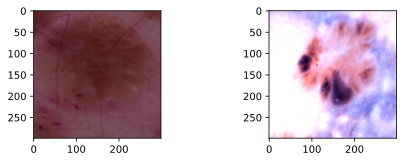

In [13]:
# Прсмотрим несколько картинок после применения аугментации.

from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,2):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

In [ ]:
imgs, labels = next(train_generator)
print(imgs.shape, labels.shape)

# Посмотрим распределение данных по классам.

In [ ]:

def classes_count (path):
    # определяет содержимое папок классов
    
    classes = []
    for filename in iglob(os.path.join(train_path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])
    cnt = Counter(classes)
    return cnt

def percentage_value(pct, allvals):
    # вычисляет процентное значение размера класса
    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset_description(path, title):
    # строит круговую диаграмму
    
    classes_cnt = classes_count(path)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()

In [ ]:
plot_dataset_description(os.path.join(train_path), "Содержание обучающей выборки")

In [ ]:
plot_dataset_description(os.path.join(test_path), "Содержание тестовой выборки")

In [ ]:
def plot_dataset_description_bar(path, title):
    # строит диаграмму столбиками
 
    classes_val = classes_count(path)
    

    values = list(classes_val.values())
    labels = list(classes_val.keys())

    index = [n for n in range(numberOfClass)]
    plt.figure(figsize=(10, 5))
    #hist, bins = np.histogram(values, bins=9)
    plt.bar( values, values, width=10)
 #   plt.bar(range(len(values)),[values[k] for k in values], width=20)
    
    #plt.xlabel('Градация болезней', fontsize=10)
    plt.ylabel('Количество картинок', fontsize=10)
    plt.xticks(values, labels, fontsize=8, rotation=90)
    plt.title(title)

In [ ]:
plot_dataset_description_bar(os.path.join(train_path), 'Содержание примеров в обучающей выборке')

In [ ]:
imgs, labels = next(test_generator)
print(imgs.shape, labels.shape)
print(len(train_generator))

# Построение и обучение модели.

In [ ]:
#model = keras.models.load_model('/kaggle/input/inputmod/best_model_step1.hdf5')

## Вынесем функции для раздела построения и обучения модели.

In [14]:
def info_layers():
    # вывод информации по слоям модели в процессе тюнинга
    
    print("Number of layers in the model:", len(model.layers))
    print("Number of trainable_variables layers in the model:", len(model.trainable_variables))
    print("Number of layers in the base model: ", len(base_model.layers))
    print("Number of variables layers in the base model: ", len(base_model.trainable_variables))
    print("Layers in the model:")
    for layer in model.layers:
        print(layer, layer.trainable)

def graph(history):
    # построние графиков изменения метрики и функции потерь в процессе обучения по эпохам
    
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], 'b*-', label="training acc")
    plt.plot(history.history['val_accuracy'], 'r*-', label="validation acc")
    plt.grid()
    plt.title("train_acc vs val_acc")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], 'b*-', label="training loss")
    plt.plot(history.history['val_loss'], 'r*-', label="validation loss")
    plt.grid()
    plt.title("Training and validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    
    


In [15]:
# CallBack для сохранения модели, ее весов и лучшей модели
weightpath = "best_model.hdf5"
checkpoint = ModelCheckpoint(weightpath , monitor = 'val_accuracy' , mode = 'max', verbose = 1,save_best_only=True) #save_weights_only=True, save_best_only=True,
#checkpoint = ModelCheckpoint(weightpath , monitor = ['val_accuracy'] , save_best_only=True)
reducer = ReduceLROnPlateau(monitor='loss', patience= 3,factor=0.2, min_lr=0.0000001,  verbose = 1, cooldown=2, mode='auto',min_delta=0.0000001) #min_delta=0.000000001
early_stop= EarlyStopping(monitor='loss',patience= 10, mode='min')  #min_delta=0.000000001
#early_stop= EarlyStopping(monitor='val_accuracy',patience= 10, restore_best_weights=True)

In [16]:
# EarlyStopping для остановки обучения, когда отслеживаемый показатель перестал улучшаться.

#early_stop= EarlyStopping(min_delta=0.001, verbose=1, mode="max", restore_best_weights=False) #  patience=7,

#callbacks_list = [checkpoint] #, early_stop]
callbacks_list = [checkpoint, reducer, early_stop] #reducer

## Шаг1  Сформирмируем сверточную нейросеть CNN

In [17]:
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)

71688192/71686520 [==============================] - 1s 0us/step


In [18]:
# Установим все слои base_model в неактивное состояние

base_model.trainable = False

In [ ]:
model=Sequential()
model.add(base_model)

#model.add(GlobalAveragePooling2D(),)
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
#model.add(BatchNormalization())
print('ок')
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
#model.add(L.Dense(512,activation='relu'))
#model.add(L.BatchNormalization())
model.add(Dense(numberOfClass, activation='softmax'))

In [19]:
# лучшая модель 22%

model=Sequential()
model.add(base_model)

#model.add(GlobalAveragePooling2D(),)
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.15))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.2))
#model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#model.add(MaxPooling2D())
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
print('ок')
model.add(Flatten())
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
#model.add(L.Dense(512,activation='relu'))
#model.add(L.BatchNormalization())
model.add(Dense(numberOfClass, activation='softmax'))

ок


In [20]:
# Посмотрим информацию о количестве слоев модели и модели Imagenet

info_layers()

Number of layers in the model: 13
Number of trainable_variables layers in the model: 12
Number of layers in the base model:  474
Number of variables layers in the base model:  0
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f7c018974d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b8c535ed0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f77b83f4a90> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f77b891afd0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f77b83fb610> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f77b8403ed0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f7b8c535d50> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f77b83fb250> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f77b83fec90> True
<tensorflow.python.kera

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 10, 10, 1792)      17673823  
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 64)        1032256   
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 10, 10, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 256)         147712    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 256)         1

In [ ]:
# Посмотрим структуру модели

model.summary()

In [ ]:
# Посмотрим на схему модели.

from tensorflow.keras import utils

utils.plot_model(model)

In [22]:
# Компилируем модель

LR=0.001
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [23]:
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 10, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
300/300 [==============================] - 136s 410ms/step - loss: 2.4514 - accuracy: 0.2122 - val_loss: 2.0158 - val_accuracy: 0.1959

Epoch 00001: val_accuracy improved from -inf to 0.19595, saving model to best_model.hdf5
Epoch 2/10
300/300 [==============================] - 82s 273ms/step - loss: 2.0416 - accuracy: 0.2058 - val_loss: 2.0194 - val_accuracy: 0.1959

Epoch 00002: val_accuracy did not improve from 0.19595
Epoch 3/10
300/300 [==============================] - 83s 276ms/step - loss: 2.0595 - accuracy: 0.1914 - val_loss: 2.0140 - val_accuracy: 0.2072

Epoch 00003: val_accuracy improved from 0.19595 to 0.20721, saving model to best_model.hdf5
Epoch 4/10
300/300 [==============================] - 81s 271ms/step - loss: 2.0222 - accuracy: 0.2032 - val_loss: 2.0126 - val_accuracy: 0.2072

Epoch 00004: val_accuracy did not improve from 0.20721
Epoch 5/10
300/300 [==============================] - 82s 273ms/step - loss: 2.0423 - accuracy: 0.1909 - val_loss: 2.0135 - 

In [25]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_s91.hdf5')
model.load_weights('best_model.hdf5')

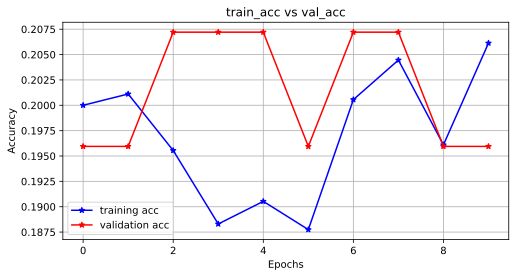

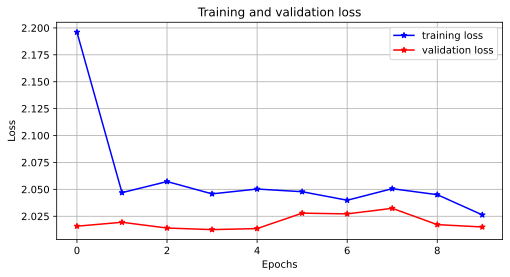

In [26]:
graph(history)

In [ ]:
шаг2

In [27]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 383

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

In [ ]:
# Посмотрим структуру модели

model.summary()

In [28]:
# Компилируем модель

LR=0.0003
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


In [29]:
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 10, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/10
300/300 [==============================] - 98s 289ms/step - loss: 2.0613 - accuracy: 0.1625 - val_loss: 2.0121 - val_accuracy: 0.2072

Epoch 00001: val_accuracy did not improve from 0.20721
Epoch 2/10
300/300 [==============================] - 84s 282ms/step - loss: 2.0547 - accuracy: 0.2035 - val_loss: 2.0307 - val_accuracy: 0.2072

Epoch 00002: val_accuracy did not improve from 0.20721
Epoch 3/10
300/300 [==============================] - 84s 281ms/step - loss: 2.0453 - accuracy: 0.1858 - val_loss: 2.0134 - val_accuracy: 0.2072

Epoch 00003: val_accuracy did not improve from 0.20721
Epoch 4/10
300/300 [==============================] - 84s 281ms/step - loss: 2.0468 - accuracy: 0.1949 - val_loss: 2.0131 - val_accuracy: 0.2072

Epoch 00004: val_accuracy did not improve from 0.20721
Epoch 5/10
300/300 [==============================] - 84s 280ms/step - loss: 2.0454 - accuracy: 0.1940 - val_loss: 2.0115 - val_accuracy: 0.2072

Epoch 00005: val_accuracy did not improve from 0.2

In [32]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_s92.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
graph(history)

In [ ]:
# Шаг3

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 68

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [ ]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

In [ ]:
# Посмотрим структуру модели

model.summary()

In [ ]:
# Компилируем модель

LR=0.0003
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 15, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_st3.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
graph(history)

In [ ]:
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 12, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

In [ ]:
#print("Straturi:")
#for i, layer in enumerate(model.layers[:30]):
#    print(i, layer.name)
#    layer.trainable = False

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_step2.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
model.load_weights('/kaggle/input/inputmod/best_model_step1.hdf5')

In [ ]:
graph(history)

In [ ]:
#history=model.save('model_last.hdf5')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Результаты

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
scores = model.evaluate_generator(test_val_generator, steps=len(test_val_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
scores

In [ ]:
scores2 = model.predict(test_val_generator)  #np.argmax(probabilities)

In [ ]:
scores2

In [ ]:
scores = model.evaluate_generator(scores2, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

## Confugn matrix по тестовым данным

In [ ]:
%%time
Y_pred = model.predict_generator(test_generator,verbose=1)  # test_val_generator
Y_pred

In [ ]:
y_pred2 = np.argmax(Y_pred, axis=1)
y_pred2

In [ ]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred2)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

In [ ]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

In [ ]:
list(classes.values())

In [ ]:
plot_confusion_matrix(cnf_matrix, list(classes.values()))

In [ ]:
# классификация ответов

print(classification_report(test_generator.classes, y_pred2, target_names=list(classes.values())))

In [ ]:
# Confugn matrix по валидационным данным

In [ ]:
%%time
Y_pred1 = model.predict_generator(test_val_generator,verbose=1)  # test_val_generator
y_pred_val = np.argmax(Y_pred1, axis=1)
y_pred_val

In [ ]:
cnf_matrix_val = confusion_matrix(test_val_generator.classes, y_pred_val)
classes = {v: k for k, v in test_val_generator.class_indices.items()}
print(classes)

In [ ]:
plot_confusion_matrix(cnf_matrix_val, list(classes.values()))

In [ ]:
# классификация ответов

print(classification_report(test_val_generator.classes, y_pred_val, target_names=list(classes.values())))

# Tестовая демонстрация.

In [ ]:
def load_image(filename):
    # загружает картинку
    
    img = cv2.imread(os.path.join(train_path, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    return img

def predict(image):
    # возвращает первые три максимальных значений из предсказанных для каждого класса
    tta_step = 3
    predictions = []
    for i in range(tta_step):
        preds = model.predict(np.asarray([img]))[0]
        predictions.append(preds)
    pred = np.mean(predictions, axis=0)
    probabilities = pred
#    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = (-probabilities).argsort()[:3]  # np.argmax(probabilities)
    return class_idx, probabilities[class_idx]

In [ ]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

In [ ]:
img2=load_image(train_path + 'Vascular Tumors/angiokeratomas-18.jpg')

In [ ]:
img3=np.asarray([img2])
img3

In [ ]:
pr = model.predict(img3)[0]

In [ ]:
pr

In [ ]:
class_idx1 = np.argmax(pr)
class_idx1

In [ ]:
class_idx2 = (-pr).argsort()[:3] 
class_idx2

In [ ]:
prediction

In [ ]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 3)):    # test_val_generator
    print("Источник: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][0]], prediction[1][0]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][1]], prediction[1][1]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][2]], prediction[1][2]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
# TTA

In [ ]:
tta_step = 10 
predictions = []

In [ ]:
tta_step = 5 
predictions = []
for i in range(tta_step):
    preds = model.predict_generator(test_generator, verbose = 1)
    predictions.append(preds)
pred = np.mean(predictions, axis=0)

In [ ]:
predictions

In [ ]:
pred = np.mean(predictions, axis=0)

In [ ]:
pred

In [ ]:
#predictions = np.argmax(pred, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())


In [ ]:
label_map

In [ ]:
predictions

In [ ]:
predictions = [label_map[k] for k in pred]
predictions

In [ ]:
pred[0]

In [ ]:
predictions[0][2][0]

# Сохранение модели для продакшн

In [ ]:
channel.queue_declare(queue='Features')

In [ ]:
def callback(ch, method, properties, body):
    print(f'Получен вектор признаков {body}')

In [ ]:
# on_message_callback показывает какую функцию вызвать при получении сообщения
channel.basic_consume(
    queue='Features', on_message_callback=callback, auto_ack=True)
print('...Ожидание сообщений, для выхода нажмите CTRL+C')

In [ ]:
channel.start_consuming()

In [ ]:
import pika
      ___(1)___
connection = ___(2)___(
    pika.ConnectionParameters(host='localhost'))
      ___(3)___ = connection.channel()

channel.queue_declare(queue='y_true')
channel.queue_declare(___(4)___)

def ___(5)___(ch, method, ___(6)___, body):
    print(f'Из очереди {method.routing_key} получено значение {json.loads(___(7)___)}')

channel.basic_consume(
    queue='y_predict', on_message_callback=callback, auto_ack=True)

channel.basic_consume(
      queue=___(8)___, on_message_callback=callback, auto_ack=True)

print('...Ожидание сообщений, для выхода нажмите CTRL+C')
      channel.___(9)___()

In [ ]:
plot_any([test_binary, new_img, final_result])